In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import importlib
import nbimporter
import data_scraping
import data_cleaning
pd.options.display.min_rows = 20

In [2]:
importlib.reload(data_scraping)
importlib.reload(data_cleaning)

<module 'data_cleaning' from 'data_cleaning.ipynb'>

# 1. Scraping Data
We scrape the results of:

- Presidential elections for each state since 1789 to 2020

- Senator elections for each state from 1789 to 2020

- House representatives for each state from 1789 to 2022

- Governors for each state from 1789 to 2020, although this period range varies for each state depending on wether they held elections or not.

We use the module contained in scraping_module.py. This module is the exact same code than the jupyter notebook 01_scraping_data.ipynb

In the cell below, uncoment the two lines corresponding to each election that you would like.

In [3]:
## ------------- president elections
# file_name = 'presidential_by_state.csv'
# data_scraping.president_elections(file_name)

## ------------- senate elections
# file_name = 'senate_by_state.csv'
# data_scraping.senate_elections(file_name)

## ------------- house representatives elections
## Warning: takes a long time!
# file_name = 'house_by_state3.csv'
# data_scraping.house_elections(file_name)

## ------------- governor elections
# file_name = 'governor_by_state.csv'
# data_scraping.governor_elections(file_name)

# 2. Cleaning Data

We clean the data for each election, by removing unwanted strings, unwanted columns, etc. We use the module in clean_module.py, this module is the same as contained on the notebook 02_cleaning_data.ipynb. The notebook presents further information

In [4]:
path = '/Users/Angeles/Desktop/USA_elections/'

dfpi = pd.read_csv(path + 'presidential_by_state.csv')
dfp = data_cleaning.clean_president(dfpi)

dfsi = pd.read_csv(path + 'senators_by_state.csv')
dfs = data_cleaning.clean_senate(dfsi)

dfhi = pd.read_csv(path+'house_by_state.csv')
dfh = data_cleaning.clean_house(dfhi)

dfgi = pd.read_csv(path+'governors_by_state.csv')
dfg = data_cleaning.clean_governor(dfgi)

## Unstacking and Merging the datasets

First, we need to change the shape of the dataframes. The Presidential, Senatorial and Guvernatorial elections have one elected candidate per year. Instead, the House of representative have multiple elected cancidates per year.

The image below shows the differnce between guvernatorial and house elections. 

Then, we change each table to have three columns "D", "R" and "O", for "democrat", 'republican', 'other'. In this way, we can count the number of elected people by year and party.

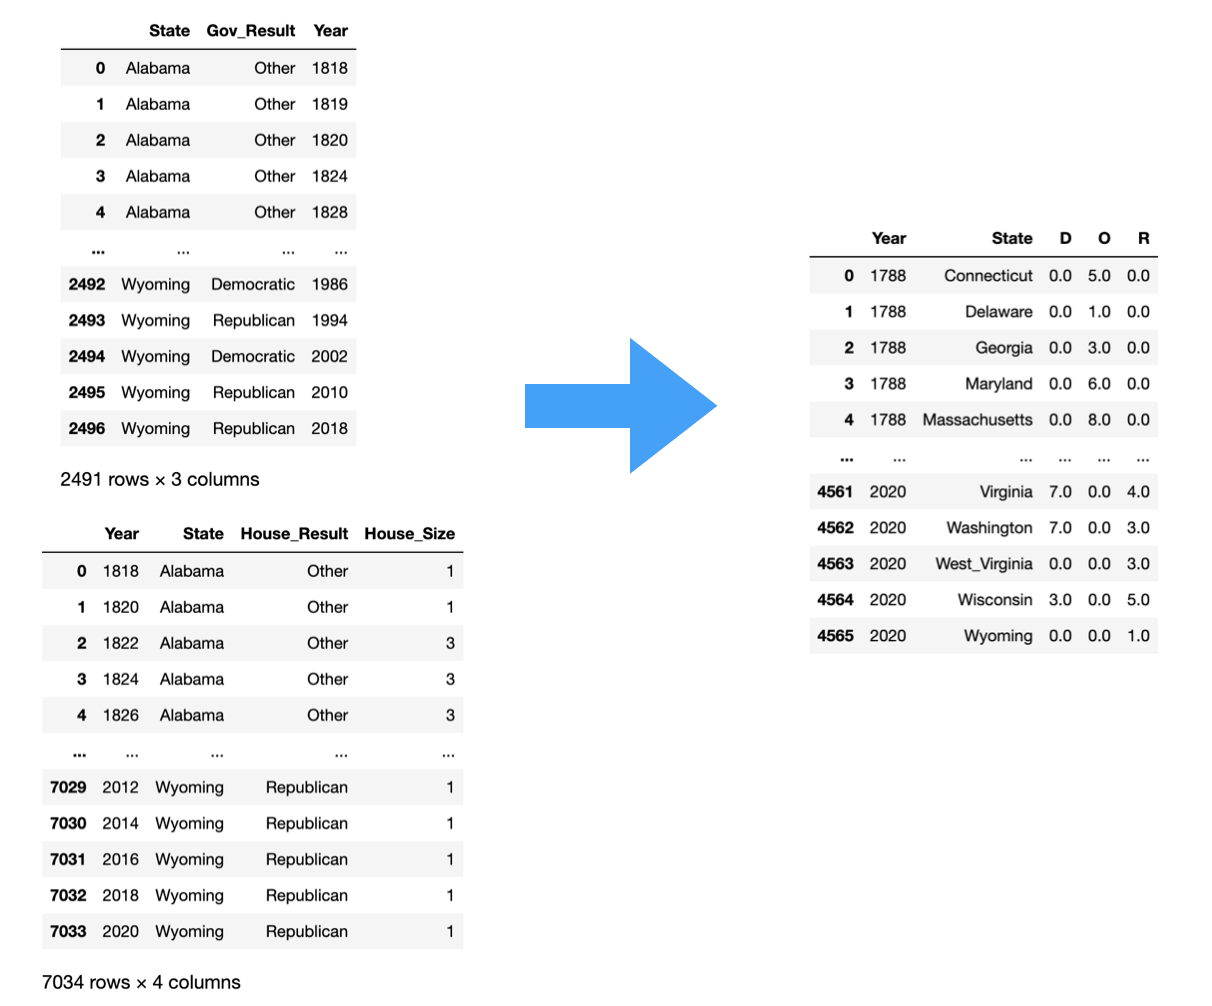

#### - Unstack House dataset

In [5]:
h_ustck = (dfh
    .set_index(['Year','State','House_Result'])
    .unstack('House_Result')
    .replace(np.nan, 0)
    .reset_index()
    .rename(columns={'Democratic':'D','Republican':'R','Other':'O'})
)

h_ustck.columns = h_ustck.columns.droplevel(level=0)
h_ustck.rename_axis(None,axis=1,inplace=True)
h_ustck.columns = ['Year','State','D','O','R']

#### - Unstack Senate, President and Governors

In [6]:
def new_columns(df, names):
    df.columns = names
    return(df)


def parties_unstack_count(df, branch, names):
    return(df.groupby(['State','Year', branch+'_Result'])
            .size()
            .to_frame(name = branch+'_Size') 
            .reset_index()
            .set_index(['Year','State',branch+'_Result'])
            .unstack(branch+'_Result')
            #.replace(np.nan, 0)
            .reset_index()
            .pipe(new_columns, names) ## read WARNING for this line
            )
## WARNING!!!: check in which order are the columns returned from parties_unstack_count without the last pipe
## then you can assign the variable "names" in the correct order and activate that pipe

s_ustck = parties_unstack_count(dfs, branch='Sen', names=['Year','State','D','N','O','R'])
p_ustck = parties_unstack_count(dfp, branch='Presi', names=['Year','State','D','N','O','R'])
g_ustck = parties_unstack_count(dfg[['Year','State','Gov_Result']], branch='Gov', names=['Year','State','D','O','R'])

#### - Remove odd years
Since Senator, House and President elections are held on even years, we remove the odd years. When a governor is elected on and odd year, we move it to the closest even year

In [7]:
def remove_odd_yrs(df):
    m = df['Year']%2==0
    return (df
            .assign(Year = df['Year'].where(m, df['Year']-1))
            .groupby(['Year','State'])
            .sum()
            .reset_index()  
            )

In [8]:
# individual datasets
h_ustck =  remove_odd_yrs(h_ustck)
p_ustck =  remove_odd_yrs(p_ustck)
s_ustck =  remove_odd_yrs(s_ustck)
g_ustck =  remove_odd_yrs(g_ustck)
# merged dataset 
#df_all =  remove_odd_yrs(df_all)

#### - Rename columns 
In each dataset, according to the government branch they belong to

In [9]:
p_ustck.rename(columns={'D':'D_p','N':'N_p','O':'O_p','R':'R_p'}, inplace=True)
s_ustck.rename(columns={'D':'D_s','N':'N_s','O':'O_s','R':'R_s'}, inplace=True)
g_ustck.rename(columns={'D':'D_g','O':'O_g','R':'R_g'}, inplace=True)
h_ustck.rename(columns={'D':'D_h','O':'O_h','R':'R_h'}, inplace=True)

#### -Merge all branches together

In [10]:
from functools import reduce
dfs = [p_ustck, s_ustck, h_ustck, g_ustck]
datasets = reduce(lambda  left,right: pd.merge(left,right,on=['Year','State'],
                                            how='outer'), dfs).sort_values(by=['Year'])

#### - Rremove years

All data before 1850 are removed, since before 1850 the government underwent several changes, and unstability of small parties makes it harder to identify them.
Data after 2019 is also removed, because some datasets are incomplete after 2019.


In [11]:
datasets=datasets[(datasets['Year']>=1850) & (datasets['Year']<2020)].reset_index()

In [12]:

datasets

,index,Year,State,D_p,N_p,O_p,R_p,D_s,N_s,O_s,R_s,D_h,O_h,R_h,D_g,O_g,R_g
0,3722,1850,Minnesota,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,3701,1850,Alaska,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3729,1850,New_Jersey,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0
3,3730,1850,New_Mexico,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,3731,1850,New_York,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,17.0,17.0,0.0,0.0,1.0,0.0
5,3732,1850,North_Carolina,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,3.0,6.0,0.0,0.0,1.0,0.0
6,3733,1850,North_Dakota,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7,3734,1850,Ohio,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,10.0,11.0,0.0,NaN,NaN,NaN
8,3735,1850,Oklahoma,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
9,3736,1850,Oregon,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


#### - Add state codes

This is necesary to create a map in the dashboard

In [13]:
dict_codes = {'Alabama': 'AL',
 'Alaska': 'AK',
 'Arizona': 'AZ',
 'Arkansas': 'AR',
 'California': 'CA',
 'Colorado': 'CO',
 'Connecticut': 'CT',
 'Delaware': 'DE',
 'Florida': 'FL',
 'Georgia': 'GA',
 'Hawaii': 'HI',
 'Idaho': 'ID',
 'Illinois': 'IL',
 'Indiana': 'IN',
 'Iowa': 'IA',
 'Kansas': 'KS',
 'Kentucky': 'KY',
 'Louisiana': 'LA',
 'Maine': 'ME',
 'Maryland': 'MD',
 'Massachusetts': 'MA',
 'Michigan': 'MI',
 'Minnesota': 'MN',
 'Mississippi': 'MS',
 'Missouri': 'MO',
 'Montana': 'MT',
 'Nebraska': 'NE',
 'Nevada': 'NV',
 'New_Hampshire': 'NH',
 'New_Jersey': 'NJ',
 'New_Mexico': 'NM',
 'New_York': 'NY',
 'North_Carolina': 'NC',
 'North_Dakota': 'ND',
 'Ohio': 'OH',
 'Oklahoma': 'OK',
 'Oregon': 'OR',
 'Pennsylvania': 'PA',
 'Rhode_Island': 'RI',
 'South_Carolina': 'SC',
 'South_Dakota': 'SD',
 'Tennessee': 'TN',
 'Texas': 'TX',
 'Utah': 'UT',
 'Vermont': 'VT',
 'Virginia': 'VA',
 'Washington': 'WA',
 'West_Virginia': 'WV',
 'Wisconsin': 'WI',
 'Wyoming': 'WY'}

In [14]:
datasets["code"] = datasets["State"].map(dict_codes)

#### - Remove Errors





The House of Representatives has some States listed as "Error". This is an Error from the website where I scraped the data. There are two options, 1- find out the state of each congress member that has the error. 2- remove these memebers. Since I dont have time to look the state of each memebr, I decided to reove them. In the future I would like to add the correct states.


In [15]:
datasets= datasets.drop(datasets[(datasets.State=='Error')].index).drop(datasets[(datasets.State=='District_of_Columbia')].index)

#### - Necesary functions to process data

In [16]:
## this calculates the percentage of each party compared to the total
## it can be calculated for senate (_s), president (_p), house (_h),gobernors (_g)
## or any combination of those. the sufixs have to be inside a list ex: ['_h'] ex2: ['_p','_g']
def percentage_dominance(sufixs, datasets):
    cols = [b+s for b in ['D','R','O'] for s in sufixs]
    Dcols = ['D' + s for s in sufixs]
    Rcols = ['R' + s for s in sufixs]
    Ocols = ['O' + s for s in sufixs]

    DDs = 100*(datasets[Dcols].sum(axis=1)/datasets[cols].sum(axis=1))#.fillna(0)
    OOs = 100*(datasets[Ocols].sum(axis=1)/datasets[cols].sum(axis=1))#.fillna(0)
    RRs = 100*(datasets[Rcols].sum(axis=1)/datasets[cols].sum(axis=1))#.fillna(0)

    return(DDs, OOs, RRs)


# This functions multiply the republican values by -1, so when we plot in the map, they look red in the colorscale
def negative_value_republicans(datasets, percents=['D_prcnt','R_prcnt','O_prcnt']): 
    # branches must be a list in order : democrats, others, republicans
    # choose from: %D_total, %D_p, %D_h, %D_
    
    
    winner = datasets[percents].max(axis=1)
    
    conditions = [
   (datasets[['D_prcnt','O_prcnt','R_prcnt']].idxmax(axis=1)=='D_prcnt') & (datasets[['D_prcnt','O_prcnt','R_prcnt']].max(axis=1)!=0),
    (datasets[['D_prcnt','O_prcnt','R_prcnt']].idxmax(axis=1)=='R_prcnt') & (datasets[['D_prcnt','O_prcnt','R_prcnt']].max(axis=1)!=0),
                ]
    choices = [1,-1]

    datasets['branches_winner'] = np.select(conditions, choices, default=0)
    datasets['value_branches'] = winner*datasets['branches_winner']

## 3 Dashboard app

In [17]:
import pandas as pd
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import json

To look into resizing figures when browser is resized look at:
    
    https://community.plotly.com/t/how-to-trigger-callback-if-user-manually-resizes-their-window/69762/3
    
Learn how to :

https://dash.plotly.com/interactive-graphing

To look for good examples:

https://dash-example-index.herokuapp.com/box-plots

In [18]:

# external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

# app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

app = JupyterDash(__name__)

#app.css.append_css({'external_url':'https://codepen.io/chriddyp/pen/bWLwgP.css'})

In [19]:
# %%bash
# #pip install plotly==5.4 dash jupyter-dash
# ## the directory assets is inside this notebook's directory
# mkdir assets/
# wget https://gist.githubusercontent.com/escape-velocity-labs/17c3ba12aef542afe5055a859e0fbd98/raw/af9e2431fb69c76618aeec9940cd5fd6deab8b1f/style.css -O assets/style.css

### 3.1 Create plots

#### 3.1.1 Time series of political dominance

In [20]:
## to apply a style for the title we can give it a unique id, or we can group in a class so 
## all the elements belonging to that class have the same style

trend_title = html.P(className="chart-header", children='Evolution of parties dominance')

In [21]:
@app.callback(Output('trend-graph', 'figure'), 
              [Input('map-graph', 'clickData'),
                  
             #Input('state-dropdown', 'value'),
               Input('checklist-branch1', 'value'),
              Input('dropdown-mode', 'value')])
def update_trend_graph(clickData,branches, modelplt):
    statecode = 'AL'
    if clickData:
        statecode = clickData['points'][0]['location']

    datasets2 = 0
    if statecode == 'All':
        cols = [b+s for b in ['D','R','O'] for s in branches]
        datasets1 = datasets[['Year']+cols].groupby(['Year']).sum().reset_index()
        dd,oo,rr = percentage_dominance(branches, datasets1)
        subset = datasets1.assign( D_prcnt = dd, O_prcnt = oo, R_prcnt = rr )
    else:      
        dd,oo,rr = percentage_dominance(branches, datasets)
        datasets2 = datasets.assign( D_prcnt = dd, O_prcnt = oo, R_prcnt = rr )
        subset = datasets2.query(f"code == '{statecode}'")
        
    fig = go.Figure()#fig = go.Figure(layout=layout)
    
##**************************** add rolling mean plot ************************    
    if modelplt == 'rolling':
        
        subset2 = subset.rolling(5,axis=0).mean()
        fig.add_trace(go.Scatter(x=subset2['Year'], y=subset2['D_prcnt'],
                        line = dict(color='royalblue', width=2),
                        mode='lines',
                        connectgaps = True,
                        showlegend =False
                        ))
        fig.add_trace(go.Scatter(x=subset2['Year'], y=subset2['R_prcnt'],
                        line = dict(color='firebrick', width=2),
                        mode='lines',
                        connectgaps = True,
                        showlegend =False
                        ))
        fig.add_trace(go.Scatter(x=subset2['Year'], y=subset2['O_prcnt'],
                        line = dict(color='teal', width=2),
                        mode='lines',
                        connectgaps = True,
                        showlegend =False
                        )) 
        modelplt = 'markers'
##***************************************************************************    
        
    
    fig.add_trace(go.Scatter(x=subset['Year'], y=subset['D_prcnt'],
                    line = dict(color='royalblue', width=2),
                    mode=modelplt,
                    connectgaps = True,
                    name='Democrats'))
    fig.add_trace(go.Scatter(x=subset['Year'], y=subset['R_prcnt'],
                    line = dict(color='firebrick', width=2),
                    mode=modelplt,
                    connectgaps = True,
                    name='Republicans'))
    fig.add_trace(go.Scatter(x=subset['Year'], y=subset['O_prcnt'],
                    line = dict(color='teal', width=2),
                    mode=modelplt,
                    connectgaps = True,
                    name='Others')) 
    
    
    
    fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)",
                     title=datasets[datasets['code']==statecode]['State'].unique()[0],
                xaxis_title="Year",
                yaxis_title="Dominance",
                legend_title="Party",
                font=dict(
                    family="Sans Serif",
                    size=16,
                    color="black"
                    ))

    del datasets2
    return fig

#### 3.1.2 Dsplay hover data

In [22]:
@app.callback(
    Output('hover-data', 'children'),
    Input('trend-graph', 'hoverData'),
    Input('map-graph', 'clickData'),)
def display_hover_data(hoverData, clickData):
    year = hoverData['points'][0]['x']
    statecode = "AL" # default is alabama
    if clickData:
        statecode = clickData['points'][0]['location']
   
    if statecode != 'All':
    

        subset = datasets.query(f'Year == {year} & code == "{statecode}"')[['D_p','R_p','O_p','D_s','R_s','O_s','D_h','R_h','O_h','D_g','R_g','O_g']]


        president = 'No elections'
        if subset['D_p'].item() == 1:
            president = "Democrat"
        elif subset['R_p'].item() == 1:
            president = 'Republican'
        elif subset['O_p'].item() == 1:
            president = 'Other'

        gobernor = 'No elections'
        if subset['D_g'].item() >= 1:
            gobernor = "Democrat"
        elif subset['R_g'].item() >= 1:
            gobernor = 'Republican'
        elif subset['O_g'].item() >= 1:
            gobernor = 'Other'

        senator = 'No elections'
        if subset['D_s'].item() >= 1:
            senator = "Democrat"
        elif subset['R_s'].item() >= 1:
            senator = 'Republican'
        elif subset['O_s'].item() >= 1:
            senator = 'Other'

        house_other = str(subset['O_h'].item()) + ' Other'
        house_democrat = str(subset['D_h'].item()) + ' Democrats'
        house_republican = str(subset['R_h'].item() ) + ' Republicans' 


        chunks = [
            'Year:' + str(year),
            'President (state total): '+ president,
            'Senator: ' + senator,
            'House: ' + str(house_democrat),
            '       ' + str(house_republican),
            '       ' + str(house_other),
            'Gobernor: ' + gobernor
            ]

    else:
        subset = datasets.query(f'Year == {year}')[['D_p','R_p','O_p','D_s','R_s','O_s','D_h','R_h','O_h','D_g','R_g','O_g']]

        chunks = [
            'Year:' + str(year),
            'President: '+ str(subset['D_p'].sum()) + ' Democrats',
            '           '+ str(subset['R_p'].sum()) + ' Republicans',
            '           '+ str(subset['O_p'].sum()) + ' Others',
            '                     ',
            'Senator: ' + str(subset['D_s'].sum()) + ' Democrats',
            '         ' + str(subset['R_s'].sum()) + ' Republicans',
            '         ' + str(subset['O_s'].sum()) + ' Others',
            '                     ',
            'House: ' + str(subset['D_h'].sum()) + ' Democrats',
            '       ' + str(subset['R_h'].sum()) + ' Republicans',
            '       ' + str(subset['O_h'].sum()) + ' Others',
            '                     ',
            'Gobernor: ' + str(subset['D_g'].sum()) + ' Democrats',
            '          ' + str(subset['R_g'].sum()) + ' Republicans',
            '          ' + str(subset['O_g'].sum()) + ' Others',
            ]
        
        
    return [html.P(children=chunk) for chunk in chunks]


#### 3.1.3 Map of elections

In [23]:
@app.callback(Output('map-graph', 'figure'), 
              [Input('year-dropdown', 'value'),
               Input('checklist-branch1', 'value')])
def update_map_graph(year, branches):


    
    datasets2 = 0
    dd,oo,rr = percentage_dominance(branches, datasets)
    datasets2 = datasets.assign( D_prcnt = dd, O_prcnt = oo, R_prcnt = rr )
    negative_value_republicans(datasets2)
    
    fig = px.choropleth(datasets2[datasets2.Year == year], 
                        color='value_branches',
                        locations='code',
                        locationmode='USA-states', 
                        color_continuous_scale=px.colors.sequential.RdBu,
                           #range_color=(0, 12),
                        scope="usa",
                        labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(
        coloraxis_colorbar=dict(
        title="% Dominance",
        dtick=25,
        tickmode="array",
        tickvals=[100, 75, 50, 25, 0, -25, -50, -75, -100],
        ticktext=["100","75", "50", '25', "0",'25', "50", "75", "100" ],
            )
        )

    
#     fig = go.Figure(data=go.Choropleth(
#         locations=datasets['code'],
#         z=datasets[datasets.Year == year][['code','value_branches']],
#         locationmode='USA-states',
#         colorscale=px.colors.diverging.RdBu,
#         #color_continuous_scale=px.colors.diverging.RdBu,
#         #color_continuous_midpoint=0,
#         autocolorscale=False,
#         #text=df['text'], # hover text
#         marker_line_color='white', # line markers between states
#         colorbar_title="Millions USD"
#     ))
#     fig.update_layout(
#         title_text=f'{year}',
#         geo = dict(
#             scope='usa',
#             projection=go.layout.geo.Projection(type = 'albers usa'),
#             showlakes=True, # lakes
#             lakecolor='rgb(255, 255, 255)',
#             margin={"r":0,"t":0,"l":0,"b":0}),
#    )

    return fig

### 3.2 Layout

In [24]:
app.layout = html.Div([

#***** header
    html.Div(
        id = 'header',
        children = [
        html.H4("Political distribution of government branches"),
        html.P(id = 'description',
            children = 'This application displays the evolution of the Democratic and Republican parties distribution on the Presidens, Senators, House of Representatives and Gobernors.'
              )   
                ]),
#***** second row    
    
    html.Div(className='graph-row',
        
        children = [html.Div(className='graph-container',
        
                            children = [html.Div(children=[dcc.Dropdown(
                                                id = 'year-dropdown',
                                                placeholder = 'Filter by Year',
                                                options = sorted(datasets.Year.unique().tolist()),
                                                value=2018),

                                                dcc.Checklist(
                                                   id = 'checklist-branch1',
                                                   options=[{'label':'Presidential elections', 'value':'_p'},
                                                            {'label':'Senate', 'value':'_s'},
                                                            {'label':'House of Rep.', 'value':'_h'},
                                                            {'label':'Gobernor', 'value':'_g'}],
                                                   value=['_p','_h','_s','_g'],
                                                    inline=True
                                                           ),]
                                                    , style={'width': '40%',  'color':'#6f807b'}),

                                        html.Div(
                                            children = [dcc.Graph(id='map-graph',className='graph')    
                                            ], style={'width': '100%', 'display': 'inline-block', 'color':'#6f807b'}),

                                                   ]),

                    html.Div( className='graph-container',
                            
                            children = [     

                                html.Div([ 
                                    dcc.Dropdown(
                                   id = 'dropdown-mode',
                                   options=[{'label':'line', 'value':'lines'},
                                            {'label':'markers', 'value':'markers'},
                                            {'label':'markers+lines', 'value':'lines+markers'},
                                            {'label':'rolling mean (5 election periods)', 'value':'rolling'}],
                                   value='lines+markers',
                                           )], style={'width': '40%',  'color':'#6f807b'}),
                                html.Div([    
                                    html.Div([
                                        dcc.Graph(id='trend-graph',className='row', hoverData={'points': [{'x': 1850}]})
                                                  ],             
                                
                                        style={'width': '100%', 'display': 'inline-block', 'color':'#6f807b'},
                                            ),
                                    html.Div([
                                            dcc.Markdown("""
                                                **Elections results**

                                                Move mouse over values in the graph.
                                            """),
                                            html.Pre(id='hover-data',)
                                        ], className='row',
                                        style={'width': '60%', 'display': 'inline-block', 'padding': '0 20'}
                                        ),
                                            ]),

                           ]),
    
        
        ])
    
   ])

In [25]:
app.run_server(debug=True,host='0.0.0.0', port=8015
               , mode="external")

Dash app running on http://0.0.0.0:8015/


In [26]:
# app.layout = html.Div([
    
#     html.Div(
#         id = 'header',
#         children = [
#         html.H4("Political distribution of government branches"),
#         html.P(id = 'description',
#             children = 'This application displays the evolution of the Democratic and Republican parties distribution on the Presidens, Senators, House of Representatives and Gobernors.'
#               )   
#                 ]),
    
    
#     html.Div(
        
#         [dcc.Dropdown(
#             id = 'year-dropdown',
#             placeholder = 'Filter by Year',
#             options = sorted(datasets.Year.unique().tolist()),
#             value=2018),
        
#         dcc.Checklist(
#            id = 'checklist-branch1',
#            options=[{'label':'Presidential elections', 'value':'_p'},
#                     {'label':'Senate', 'value':'_s'},
#                     {'label':'House of Rep.', 'value':'_h'},
#                     {'label':'Gobernor', 'value':'_g'}],
#            value=['_p','_h','_s','_g'],
#             inline=True
#                    ),
    
#         html.Div(className='graph-container six columns',
#             children = [dcc.Graph(id='map-graph',className='graph')    
#             ], style={'width': '60%', 'display': 'inline-block', 'color':'#6f807b'}),
    
#         ]),
    
    
#     html.Div([     

        
#         dcc.Dropdown(
#            id = 'dropdown-mode',
#            options=[{'label':'line', 'value':'lines'},
#                     {'label':'markers', 'value':'markers'},
#                     {'label':'markers+lines', 'value':'lines+markers'},
#                     {'label':'rolling mean (5 election periods)', 'value':'rolling'}],
#            value='lines+markers',
#                    ),
#         html.Div(    
#             className='graph-container six columns',
#             children =[
#                 dcc.Graph(id='trend-graph',className='graph', hoverData={'points': [{'x': 1850}]}
#                     ),             
                
#                 dcc.Markdown("""
#                      **Elections results**

#                     Move mouse over values in the graph.
#                     """),
#                     html.Pre(id='hover-data',)
#                     ], 
            
#             ),
        
#             ]),


    
#         html.Div([
#             dcc.Markdown("""
#                 **Elections results**

#                 Move mouse over values in the graph.
#             """),
#             html.Pre(id='hover-data',)
#         ], className='two columns',
#         style={'width': '30%', 'display': 'inline-block', 'padding': '0 20'}
 

#         ),
  

#     ])

/var/folders/h2/9t3ny3fn0hg9vrlqr03wl9sm0000gn/T/ipykernel_11195/1118344622.py:28: FutureWarning:

Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['State', 'code'], dtype='object')

